# Project 3: Clustering
**Group 5:** Jeff Nguyen, William Hinton, Adam Ruthford  
**09AUG2020**

# Business Understanding

# Data Understanding 1

Initial data cleaning and preparation code was derived from **Project 1**, where data types and null values were addressed.  Data were first imported into a pandas dataframe, followed by each feature getting set to the appropriate data type based on data dictionary definitions.  For example, features that have currencies are set to the float data type as they are a continuous feature; whereas features like **NewExist** is categorical in nature and set to the object data type.

In [1]:
#Import data manipulation, vizulization, and ML Packages
import pandas as pd
import time
#load data into pandas dataframe
loans = pd.read_csv('C:/Users/Jeff/Desktop/ML1/SBAnational.csv')
#loans = pd.read_csv('C:\Data\DS7331\Project\should-this-loan-be-approved-or-denied/SBAnational.csv')

C:\Users\Jeff\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


A detailed explanation for each variable follows.

**LoanNr_ChkDgt:**  Defined as an integer. This number represent a primary key that distinguishes one loan from another. The number itself is not useful for predictive purposes. However, it can be checked to ensure the dataset does not have duplicates.  

**Name:** The name of the entity receiving a loan. Defined in the data set as an object/string. As is this data would be of little use. Derived variable could be made from this column such. For instance, from the examples above all records with "DDS" could be obtained and questions could be answered about how loans to dentist performance.  
  
**City, State, Zip:** Standard geographic information fields for the loan recipient define as object/string for City and State and int for zip code. Data can be broken down by any of these columns to see if regional differences play a part in loan performance.  
  
**Bank:** The name of the bank presented as an object/string. Could be used to detail bank specific performance with respect to loan performance. Allows us to ask and answer questions like "Which bank has the worst performing loan portfolio?"

**BankState:** This column is presented as an object/string. The state the bank making the loan is located in. All references to "Bank" probably need to include the "BankState" to ensure different banks are not mixed.  
  
**NAICS:** The column is presented as an integer. "NAICS" stands for "North American Industry Classification System". This code consists of six digits, the first two digits are used to indicate the industry sector the company receiving the loan is in. The other digits in the code further identify which subsector, industry group, NAICS industry, and national industry the company receiving the loan belongs to. This will allow detailed information to be obtained on loan performance by sector. However, even the small sampling of data above reveals that missing data in the form of "0"s exist for some records and some method of accounting for the missing data will need to be devised. The following website was used in researching the [NAISC codes](https://www.naics.com/).  
  
**ApprovalDate and ApprovalFY:** These columns are presented as an object/string. The date and fiscal year the loan was approved by the SBA. Performance can be grouped by year and date, as necessary.  
  
**Term:** The column is presented as an integer. This is the loan term in months. This column can be used as a continuous variable as well as being binned and used as an ordered categorical variable, "short term", "long term" loans as an example.

**NoEmp:** The column is presented as an integer. The column contains the number of employees in the business. This column can be used as a continuous variable as well as being binned and used as an ordered categorical variable, "sole proprietorship", "under 5 employees", "between 5 and 20 employees", and "over 20 employees" as an example.

**NewExist:** The column is presented as a integer. This categorical variable indicates whether the business receiving the loan is a new or existing business. This column will need to be recoded in our dataset.

**CreateJob and RetainedJob:** These columns are presented as an integer. The column records the number of jobs created or retained respectively. These variables cannot be used as explanatory variables as they indicate the success of the loan. They are a proxy for loan  success. However, these variables can be used as the response variable in a model that would attempt to maximize job creation and or retention.

**FranchiseCode:** The column is presented as an integer. The column will need to be recast to a category. Values that have "0" or "1" indicate that the small business is not a franchise. Other values indicate the business is a franchise.

**UrbanRural:** The column is presented as an integer. The column will need to be recast to a category. The data in this column is categorical with "Urban" being a 1, "Rural" being a "2", and "0" representing "undefined".

**RevLineCr:** This column is presented as an object/string. The column indicates whether the loan is available as a revolving line of credit. The primary responses are "Y" and "N" although it appears that other values exist.

**LowDoc:** This column is presented as an object/string. The column indicates whether the loan was obtained using a one page "low document" application. The primary responses are "Y" and "N".

**ChgOffDate:** This column is presented as an object/string. As expected, many of the values in this column are "NaN". The column contains the date the loan was written off as uncollectable. Successful loans would have the value of "NaN".

**DisbursementDate:** This column is presented as an object/string. The column has the date the loan money was disbursed to the small business.

**DisbursementGross:** This column is presented as an object/string. The column needs to be converted to a numeric. The gross amount of money loaned to the small business.

**BalanceGross:** This column is presented as an object/string. The column needs to be converted to a numeric. The column contains the remaining balance of the loan.

**MIS_Status:** This column is presented as an object/string. The column is categorical data with values "P I F" and "CHGOFF". This column is the main response column of the dataset.

**ChgOffPrinGr:** This column is presented as an object/string. The column needs to be converted to a numeric. The total amount for failed loans that was non recoverable.

**GrAppv:** This column is presented as an object/string. The column needs to be converted to a numeric. The total amount approved for the loan.

**SBA_Appv:** This column is presented as an object/string. The column needs to be converted to a numeric. This column contains the total amount approved and guaranteed by the SBA.


In [2]:
#Create table containing information about features, data types, formats, and descriptions
loan_info = pd.DataFrame(columns=['Feature Name', 'Data type', 'Count','Preferred Format', 'Description'])
loan_info['Feature Name']=list(loans.columns.values) 
loan_info['Data type']= list(loans.dtypes)

loan_info['Count'] = loans.shape[0]
loan_info['Description']= ['Primary Key', ' Borrower name', 'Borrower city', 'Borrower state', 'Borrower zip code',
                        'Bank name', 'Bank state', 'NAICS Classification code','Date SBA commitment issued',
                        'Fiscal year of commitment','Loan term - months', 'Business employee count', 
                        'Existing=1 or New=2 business','Number of Jobs Created','Number of jobs retained','Franchise code',
                        'Urban=1, Rural =2, undefined = 0','Revolving line of credit: Y/N','LowDoc Loan Program: Y/N',
                        'Loan default date','Disbursement date','Disbursed armount','Gross amount outstanding',
                        'loans status','Charged-off amount','Gross amount approved by bank','SBA guaranteed amount of approved loan']

loan_info['Preferred Format'] = ['Number','Text','Text','Text','Number','Text','Text','Number','Date/Time','Text','Number','Number',
                           'Number','Number','Number','Number','Number','Text','Text','Date/Time','Date/Time','Currency',
                           'Currency','Text','Currency','Currency','Currency']                                  

#Start Table Index at 1 instead of 0
loan_info.index = loan_info.index + 1
loan_info

,Feature Name,Data type,Count,Preferred Format,Description
1,LoanNr_ChkDgt,int64,899164,Number,Primary Key
2,Name,object,899164,Text,Borrower name
3,City,object,899164,Text,Borrower city
4,State,object,899164,Text,Borrower state
5,Zip,int64,899164,Number,Borrower zip code
6,Bank,object,899164,Text,Bank name
7,BankState,object,899164,Text,Bank state
8,NAICS,int64,899164,Number,NAICS Classification code
9,ApprovalDate,object,899164,Date/Time,Date SBA commitment issued
10,ApprovalFY,object,899164,Text,Fiscal year of commitment


The table shows that this data is acceptable for use in this project as there are more than 10 features, it has over 30,000 records, and has a mix of continuous and categorical variables.

We can see that there are discrepancies between data type and preferred format.  The preferred format is the format a feature should take given if it categorical, nominal, ordinal, interval, or ratio data.  Integer and float data types should correspond to nominal, ordinal, interval, and ratio data.  While categorical data should correspond string if it is text in nature or integer if the data has several levels or is dummy coded.  Feature data types, along with missing values, duplicate data, and outliers will be address in the Data Quality section.

## Data Quality

Before addressing missing values, duplicate data and outliers, several feature data types from the raw data are not in the desired format for use.  Several features contain continuous data or date data are coded as strings and need to be converted to the apporpriate data type to allow for proper ingestion when modeling is performed.

**DisbursementGross**, **BalanceGross**, **ChgOffPrinGr**, **GrAppv**, **SBA_Appv** are features that deal with currency and are coded as strings which include '$' and ',' characters. Used this website for help with [converting currency to float.](
https://stackoverflow.com/questions/32464280/converting-currency-with-to-numbers-in-python-pandas)
  To treat these features as continuous data the special characters were removed, and the data was converted to the float data type.  This will allow for the data to be used by methods that utilize continous data.  **ApprovalDate**, **ChgOffDate**, and **DisbursementDate** are features that contain dates and were converted to the date/time data type.  This will be usefull for potential time series analysis.  **NewExist** is a categorical feature but has a float data type.  This feature was converted to an integer data type since float is better suited for continuous data.  **Zip**, **NAICS**, **FranchiseCode** are nominal features, but will be converted to strings for ease of manipulation and data cleaning.


In [3]:
import numpy as np

# Create lists of features that need their data types converted
currency = ['DisbursementGross','BalanceGross','ChgOffPrinGr','GrAppv','SBA_Appv']
date = ['ApprovalDate','ChgOffDate','DisbursementDate']
cat_variables = ['Zip']

# Convert features to appropriate data types
loans[currency] = loans[currency].replace('[\$,]', '', regex=True).astype(float)
loans[date]= loans[date].astype(np.datetime64)
loans['NewExist'] = loans['NewExist'].astype('Int64')
loans[cat_variables] = loans[cat_variables].astype(str)

In [4]:
# code gives list of columns and count of nulls and uniques values
LoanCol = pd.Series(loans.columns)
LoanCountDF = loans[LoanCol].agg(['count', 'size', 'nunique']).T
LoanCountDF['Null_Record_Count'] = LoanCountDF['size'] - LoanCountDF['count']
LoanCountDF['Number_of_Unique_Values'] = LoanCountDF['nunique']
LoanCountDF = LoanCountDF.loc[:,['Null_Record_Count','Number_of_Unique_Values']]
LoanCountDF

,Null_Record_Count,Number_of_Unique_Values
LoanNr_ChkDgt,0,899164
Name,14,779583
City,30,32581
State,14,51
Zip,0,33611
Bank,1559,5802
BankState,1566,56
NAICS,0,1312
ApprovalDate,0,9859
ApprovalFY,0,70


Names for 14 applications found in **Name** are not contained in the dataset and cannot be filled without identifying the loan applicant.  Since there are 14 rows with missing values they will be removed since they will not significantly impact the data. If unique identification of records is required **'LoanNr_ChkDgt'** values can be used to uniquely identify each row since it serves as a primary key.

**City** and **State** null values were addressed, and the methodology can be seen at the end of this section.

**Bank** contain 1559 null records and **BankState** contained 1566 missing records. It was difficult to identify a bank's state if the name of the bank is not recorded, and difficult to identify the bank's name regardless of other the other features as it must be entered at the time of application.  For these features null values were replaced as "Not Listed".

136 records were null for the **NewExist** feature.  These records were replaced with 0 to match the data type of integer for the feature and indicate that no values were entered for that particular record.

**RevLineCr** and **LowDoc** are both nominal categorical records with 4528 and 2582 missing records respectively. Missing values were replaced with "Not Provided".

**ChgoffDate** contained 736465 null values which indicates that the loan did not default.  Because this features data type is date/time were changed to '0000-00-00' to indicate that the loan is **not** in default.

The 2368 null values for **DisbursementDate** suggest that loan capital was not disbursed.  Records that did not have a disbursement date were assigned "0000-00-00" to indicate that there is no disbursement date associated with the record.

Addressing 1997 null records for **MIS_Status** was unique in that it was dependent on several attributes in the dataset. There were four different combinations of code used to address the null records for this feature.  The first combination identified null values that had a non-null value in the **ChgOffDate** feature and that the **ChgOffPrinGr** feature was not equal to zero; this combination of conditional requirements identified records that defaulted and had a charge off balance and renamed the null values as "CHGOFF".  The second combination identified null values where **DisbursementDate** was not null and the **BalanceGross** was equal to zero; this combination of features identifies records that did not receive funds and do not have a balance, this labeled the null values as "P I F".  The third and fourth combination identify null MIS_Status records where funds were not disbursed by checking **DisbursementGross** and **BalanceGross** features.  If the **DisbursementGross**was zero or null and the **BalanceGross** was 0, the missing data was labels as "Not Disbursed".

Several null values were also present in the City and State features. City contained 14 null values and State contained 30 null values. Both features describe the loan applicant's address information. For City null values, zip codes from the Zip feature and the United States Postal Service Zip Code Lookup tool (https://tools.usps.com/zip-code-lookup.htm?citybyzipcode) were used to identify the correct city or state name. Two zip-codes in City feature and two zip-codes in the State feature did not return a city in the United States and were left as 'NaN'. Since there are only 4 rows of data that do not have proper city or state data, they will be kept or removed depending on the machine learning algorithm used.

In [5]:
# Replace City NA with appropriate state/city name
cityList = ['Salt Lake City','New Orleans','Chicago','Chicago','San Diego','San Diego','San Diego','San Diego',
            'San Diego','San Diego','Clevland','St. Louis','St. Louis','St. Louis','St. Louis','St. Louis',
            'St. Louis','Seattle','Des Moines','San Antonio','Kansas City','Kansas City','Quincy','Quincy','Boston',
            'NaN','NaN','Louisville','Wilmington','Flint']
stateList = ['NaN','NaN','CA','AP','KS','TX','FL','WI','NJ','UT','MO','TX','TX','TX']

#Replace Cities with NAs with appropriate City or State    
loans.loc[loans.City.isnull(),'City'] = cityList
loans.loc[loans.State.isnull(),'State'] = stateList

A new feature called **difference_in_days** was created by subtracting DisbursementDate minus ApprovalDate.  This will explain the relationship between time the loan was approved to disbursement date. There may be some correlation to why a loan is defaulted on depending on disbursement date.

In [6]:
#Create new Time feature and convert to int
from datetime import datetime, timedelta
d1 = loans.DisbursementDate
d2 = loans.ApprovalDate
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%d-%m-%Y")
    d2 = datetime.strptime(d2, "%d-%m-%Y")
    return abs((d2 - d1).days)

difference_in_days = abs((d2-d1))/ timedelta(days=1)

loans['difference_in_days'] = difference_in_days

Addressing 1997 null records for MIS_Status was unique in that it was depedent on several attributes in the dataset. There were four different combinations of code used to address the null records for this feature. The first combination identified null values that had a non-null value in the ChgOffDate feature and that the ChgOffPrinGr feature was not equal to zero; this combination of conditional requirements identified records that defaulted and had a charge off balance and renamed the null values as "CHGOFF". The second combination identified null values where DisbursementDate was not null and the BalanceGross was equal to zero; this combination of features identifies records that did not receive funds and do not have a balance, this labeled the null values as "P I F". The third and fourth combination identify null MIS_Status records where funds were not disbursed by checking DisbursementGross and BalanceGross features. If the DisbursementGross was zero or null and the BalanceGross was 0, the missing data was labels as "Not Disbursed".

Each combination has a null count below the code to show how many of the 1997 null records remain.


In [7]:
loans['MIS_Status'].isnull().sum()

1997

In [8]:
#--------------------------------------------------------------------------------------------------------------------
#Fill In NaN fields
loans.dropna(subset = ['Name'], inplace = True)
loans["Bank"].fillna("Not Listed", inplace = True) 
loans["BankState"].fillna("Not Listed", inplace = True) 
loans['NewExist'].fillna(0, inplace = True)
loans['RevLineCr'].fillna("Not Provided", inplace = True)
loans['LowDoc'].fillna("Not Provided", inplace = True)
#loans['ChgOffDate'].fillna("0000-00-00",inplace = True)
#loans['DisbursementDate'].fillna("0000-00-00",inplace = True)

#Replace NaT MIS_status with CHGOFF if their ChgOffDate is not null
#If MIS_Status has value, 
loans['MIS_Status'].mask((loans['MIS_Status'].isnull()) & 
                         ((loans['ChgOffDate'].notnull()) |
                          (loans['ChgOffPrinGr']!=0.0)),'CHGOFF',inplace=True) 

loans['MIS_Status'].isnull().sum()

1736

In [9]:
loans['MIS_Status'].mask((loans['MIS_Status'].isnull()) &
                         (loans['DisbursementDate'].notnull()) & 
                         (loans['BalanceGross']==0.0),'P I F',inplace=True)

loans['MIS_Status'].isnull().sum()

117

In [10]:
loans['MIS_Status'].mask((loans['MIS_Status'].isnull()) &
                         (loans['DisbursementGross']==0.0) & 
                         (loans['BalanceGross']==0.0),'Not Disbursed',inplace=True)
print(loans['MIS_Status'].isnull().sum())

##Delete these records

36


In [11]:
loans.drop(loans[loans['MIS_Status'] == 'Not Disbursed'].index,inplace = True)
loans = loans.reset_index(drop=True) 
print(loans.shape)

(899069, 28)


In [12]:
loans['MIS_Status'].isnull().sum()
# delete these records instead

36

In [13]:
#--------------------------------------------------------------------------------------------------------------------
loans['MIS_Status'].replace(to_replace = 'P I F', value = 1, inplace = True)
loans['MIS_Status'].replace(to_replace = 'CHGOFF', value = 0, inplace = True)

After null values were removed, the index was reset for the loans data frame.  When rows are removed from a data frame, the index for that row remains.  If the indcies are not reset, null values will be assigned to indicies that had rows removed. Since sklearn algorithms require matricies and arrays, when a data frame with surplus incies are converted to a matrix, there will be a shape mismatch causing an error.  The .info() function was run to check on null values and the range index.

In [14]:
loans = loans.reset_index(drop=True) #resets index, important when converting to array

In [15]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899069 entries, 0 to 899068
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   LoanNr_ChkDgt       899069 non-null  int64         
 1   Name                899069 non-null  object        
 2   City                899069 non-null  object        
 3   State               899069 non-null  object        
 4   Zip                 899069 non-null  object        
 5   Bank                899069 non-null  object        
 6   BankState           899069 non-null  object        
 7   NAICS               899069 non-null  int64         
 8   ApprovalDate        899069 non-null  datetime64[ns]
 9   ApprovalFY          899069 non-null  object        
 10  Term                899069 non-null  int64         
 11  NoEmp               899069 non-null  int64         
 12  NewExist            899069 non-null  Int64         
 13  CreateJob           899069 no

### Outliers

Boxplots were used to visually identify the number of potential outliers for the continuous data in the **loans** dataframe.  The data was plotted without modification, and with values transformed using log10.  **DisbursementGross**, **BalanceGross**, **ChgOffPrinGr**, **GrAppv**, and **SBA_Appv** were plotted separately as the range of their data is much larger than **NoEmp**, **Term**, **CreateJob**, and **RetainedJob**.  Plotting these features together would have made it difficult to spot outliers since there are two groups of continuous data have vastly different ranges.  For the raw data seen in the 'Continuous Currency Features' plot a large volume of outliers are present as the amount of money considered and disbursed to a company is dependent on the small business' needs and their size.  For the 'Business Attribute Features' plot **NoEmp**, **CreateJob**, **RetainedJob** related to employees for each business and the variation and spread seen in the boxplots is dependent on the size and type of work each of the small businesses preform; due to this large spread there are also a large volume of outliers.  For **Term** the variation is much less as banks offer a limited variety of options for loan repayment, there are still several outliers as the small companies requesting longer loans may be a smaller company that prefers smaller loan payments. 

Text(0, 0.5, 'Loan Amount - $')

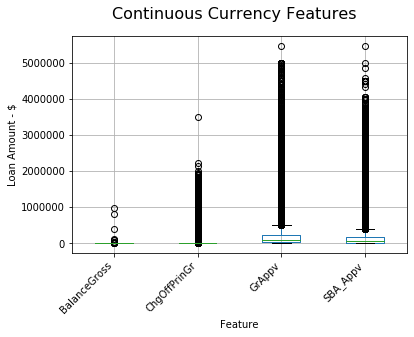

In [16]:
import matplotlib.pyplot as plt
#create matrix of continuous data
continuous_data2 = loans[['BalanceGross','ChgOffPrinGr','GrAppv','SBA_Appv']]
#plot the data
continuous_data2.boxplot()
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')
plt.suptitle('Continuous Currency Features', fontsize=16)
plt.xlabel('Feature', fontsize=10)
plt.ylabel('Loan Amount - $', fontsize=10)

Text(0, 0.5, 'Count')

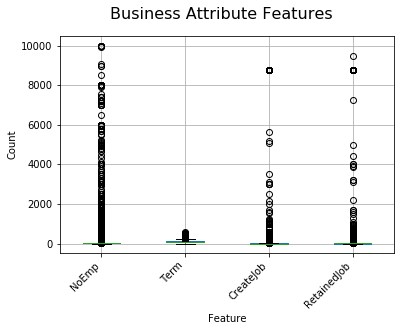

In [17]:
continuous_data1 = loans[['NoEmp','Term','CreateJob','RetainedJob']]
#plot the data
continuous_data1.boxplot()
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')
plt.suptitle('Business Attribute Features', fontsize=16)
plt.xlabel('Feature', fontsize=10)
plt.ylabel('Count', fontsize=10)

After log10 transformation GrAppv and SBA_Appr feautre appear more symetric, however still contain outliers. BalanceGross and ChgOffPrinGr appear to be all outliers. ChgoffPrinGr 737139 and BalanceGross 899136 features contain values that captures the amount of loan that is owed when it has defaulted and the remaining balance of a loan. Both ChgoffPrinGr and BalanceGross have median values of 0, with 737139 and 899136 zero values, respectively. For these features if there are large values, and much of the data is zero valued, they will show as outliers.

For the 'Business Attribute Features': NoEmp, Term, CreateJobs, and RetainedJobs contain a large number of outliers in the tails. Converting heavily skewed features removes the normality requirement for required for some machine learning algorithms.


Text(0, 0.5, 'Loan Amount - $')

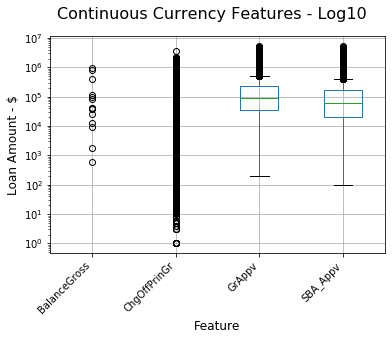

In [18]:
ax2 = continuous_data2.boxplot()
ax2.set_yscale('log')
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')
plt.suptitle('Continuous Currency Features - Log10', fontsize=16)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Loan Amount - $', fontsize=12)

Text(0, 0.5, 'Count')

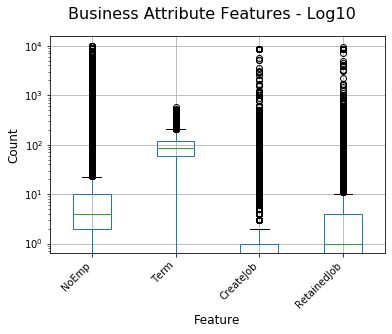

In [19]:
ax2 = continuous_data1.boxplot()
ax2.set_yscale('log')
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')
plt.suptitle('Business Attribute Features - Log10', fontsize=16)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)

Outliers will be addressed on a case-by-case basis.  Several machine learning algorithms, such as multiple linear regression (MLR), prefer data to be normal.  If MLR is used the data will be transformed via log transform or standardization and outliers can be removed if the they are egregious and significantly away from the main distribution of data. Alternatively, features with large numbers of outliers can be converted to categorical features by creating bins that capture all values within the feature of concern. For some classification algorithms normality and outliers are not a requirement of the algorithm and may not adversely affect its operation.  In these cases, the outliers may be kept.  For exploratory analysis we will keep outliers, as we will be using log distributions since they are easier to visualize and are easier to interpret.  Please see the data visualization section for more detail.

# Data Understanding 2

## Response and Explanatory Feature Descriptions, and Feature Engineering

### Response Feature

Three features in the SBAnational dataset can serve as response variables.  Two are continuous and one is categorical.  These features were choosen to be response variables as they are good indicators of loan success or failure.

**CreateJob and RetainedJob:** These columns are presented as an integer. The column records the number of jobs created or retained, respectively. These variables cannot be used as explanatory variables as they indicate the success of the loan. They are a proxy for loan success. However, these variables can be used as the response variable in a model that would attempt to maximize job creation and or retention. Thus, any of these response terms correlated with explanatory terms are significant and noteworthy due to their possible predictive power.  Since we are more interested in the classification of accounts having paid in full or were charged off; these featuers will be exclued from the model.

**MIS_Status:** This column is presented as an object/string. The column is categorical data with values "P I F" and "CHGOFF". This column is the main response column of the dataset.  This feature will be used to determine if a loan has succeeded or failed, where 'P I F' is a success, and a 'CHGOFF' is a failure.  Approximately 18% of loans were marked for a 'CHGOFF' and 82% successful repaid their loans.  This feature will serve as the response feature for our logistic and SVM models as it is dichotmous and indicates whether or not a loan applicant has paid their loan back or not.  **MIS_Status** will also be converted to numeric values instead of character for use in the model.

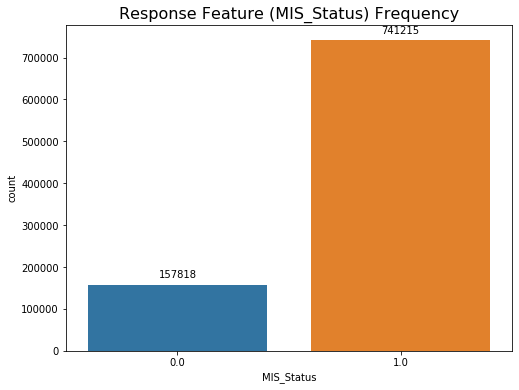

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
ax = sns.countplot(x =loans['MIS_Status'] )
plt.title("Response Feature (MIS_Status) Frequency",fontsize= 16)

for p in ax.patches:
    ax.annotate(p.get_height(),
                (p.get_x() + p.get_width() / 2, p.get_height()),  ha = 'center', va = 'center', 
                xytext = (0, 10), textcoords = 'offset points')

**ApprovalDate**, **DisbursementDate**, and **ChgOffDate** are features that contain dates.  Since there are a large volume of dates, these features would not be suited for conversion to categorical features unless they were binned.  **ApprovalFY** is similar to **ApprovalDate** and may better be suited for use in the model; this feature can be binned to reduce the number of levels in the feature. This model does not address time series analysis or autocorrelation structures.  If a record contains a value from **ChgOffDate**, then the loan defaulted.  This information is more sussenctly captured in the **MIS_Status** level 'CHGOFF'; due to the redundancy **ChgOffDate** would be more useful in a new feature that captures a time difference with another time feild.

One assumption for logistic regression is minimal multicollinearity.  **DisbursmentGross**, **GRAppv**, and **SBA_Appv** are highly correlated (r > 0.90) with each other as they all describe the amount of money that is given to a loan applicant. **SBA_Appv** will be kept, while **DisbursementGross** and **GrAppv** will be removed as they are both like **SBA_Appv**, but do not represent the final loan amount an applicant will receive.  Please see the correlation matrix in the **Data Preparation** section for more details.

**LoannNr_ChkDgt** is the primary key for this dataset.  They were removed.   
**Name** remove – there was no need to know the name of the loan applicate or business.  
**City** remove - how this might be useful we decided that there is no need to have city due to loans can originate from different cities where the applicant works and uses the loan.   
**Zip** remove – it is ideal to have the zip code of where the loan originated so we can see where the demographics of most loans are generated but that is not part of this exercise, so we got rid of the zip.   
**BankState** remove – this is not good to use because well known banks will be in most popular area and not the rural area. The demographic is skewed as we have identified in the bank state demographic graph.   
**ChgOffDate** remove – once a loan has defaulted, there is a charge off date. We are not using it.   
**Term** keep – this is a good indicator to determine if the loan will be defaulted due to the terms, some loans have short terms and most of them have long terms.   
**NoEmp** keep – this is the number of employees generated from the loan.    
**FranchiseCode** keep – this indicates what type of businesses are requesting loans and which ones are likely to pay back the loan.    
**BalanceGross** keep – this variable indicates how much needs to be repaid. Larger loan might have large balances if they are not paid back quickly.  


### Feature Engineering

**State**, **Bank**, **NAICS**, **ApprovalFY, **NewExist**, **UrbanRural**, **RevlineCr**, and **LowDoc** are features that require binning and/or one-hot-encoding.  These features may require additional cleaning and may have many categories.  Consolidating the number of categories can assist with reducing overfitting and reduce the computational load it would take to find weights for the numerous levels that exist in some of the features.

#### Categorical Features

**Bank** contains over 5,803 unique levels.  Using this many levels in a model may lead to overfitting.  To avoid this situation the large volume of banks will be reduced by consolidating and binning into nine bins.  These bins will contain the top eight banks, and an 'other' category containing the other smaller banks.  The other category was created by renaming all banks that were not in the 'major_banks' list to 'other'.  The .describe() function was then run on the modified feature to confirm that the correct number of categories were created.

In [21]:
loans['Bank'].value_counts().head(15)

BANK OF AMERICA NATL ASSOC        86847
WELLS FARGO BANK NATL ASSOC       63491
JPMORGAN CHASE BANK NATL ASSOC    48160
U.S. BANK NATIONAL ASSOCIATION    35142
CITIZENS BANK NATL ASSOC          35053
PNC BANK, NATIONAL ASSOCIATION    27351
BBCN BANK                         22978
CAPITAL ONE NATL ASSOC            22247
MANUFACTURERS & TRADERS TR CO     11262
READYCAP LENDING, LLC             10664
THE HUNTINGTON NATIONAL BANK       9605
KEYBANK NATIONAL ASSOCIATION       9259
TD BANK, NATIONAL ASSOCIATION      9007
BRANCH BK. & TR CO                 8262
ZIONS FIRST NATIONAL BANK          7954
Name: Bank, dtype: int64

In [22]:
# Banks create buckets for top 19 banks + other
major_bank = ['BANK OF AMERICA NATL ASSOC', 'WELLS FARGO BANK NATL ASSOC',
              'JPMORGAN CHASE BANK NATL ASSOC','U.S. BANK NATIONAL ASSOCIATION',
              'CITIZENS BANK NATL ASSOC','PNC BANK, NATIONAL ASSOCIATION',
             'BBCN BANK','CAPITAL ONE NATL ASSOC']

loans.loc[~loans["Bank"].isin(major_bank), "Bank"] = "Other"

A barchart was also created for the modified **Bank** to visually confirm that there are eight major banks followed by an 'other' category.  We can see that the Bank of America is one of the larger banks by loan applicaiton volume followed by Wells Fargo.  However, many loans are aquired through other banks, perhaps many of them local.  A for loop was applied to show the frequencies of loans that the banks have per bin.

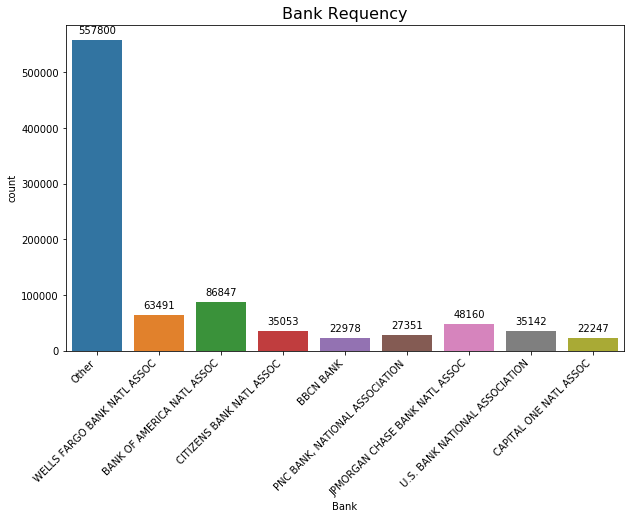

In [23]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x =loans['Bank'] )
plt.title("Bank Requency",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

for p in ax.patches:#provides frequency counts
    ax.annotate(p.get_height(),
                (p.get_x() + p.get_width() / 2, p.get_height()),  ha = 'center', va = 'center', 
                xytext = (0, 10), textcoords = 'offset points')

The North American Industry Classification System (**NAICS**) is used to classify a business into 19+ sectors that specialize in different services.  To reduce the number of levels, sectors were grouped based on similar attributes. The list of sectors can be viewed in the 'Data Dictionary' section of this link:https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied?select=SBAnational.csv 

Sectors were grouped by the first digit in their code as seen below:
- 1 Agriculture
- 2 Mining, Utilities, Construction
- 3 Manufacturing
- 4 Trade and Transportation
- 5 Professional and Scientific
- 6 Education and Health
- 7 Arts and Hospitality
- 8 other
- 9 Public Administration


In [24]:
# create NAICS bins for 0,1,2,3,4,5,6,7,8,9
'NAICS'
loans['NAICS'].replace(to_replace = 0, value = 800000, inplace = True)
loans['NAICS']= pd.cut(loans['NAICS'],
                       [100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000],
                       labels = ['1','2','3','4','5','6','7','8','9'])

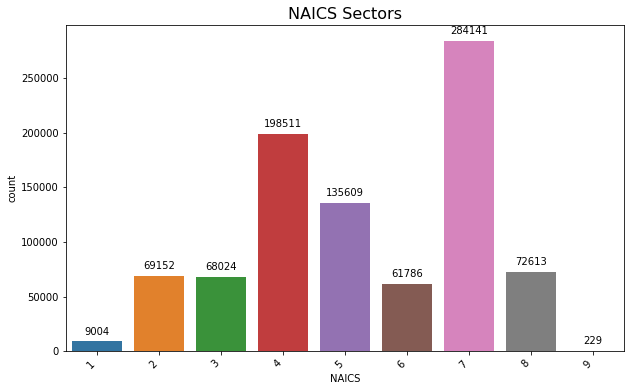

In [25]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x =loans['NAICS'] )
plt.title("NAICS Sectors",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

for p in ax.patches:
    ax.annotate(p.get_height(),
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), textcoords = 'offset points')

**RevLineCr**, or Revolving Line of Credit should have values coded "Y" or "N".  We can see that there are 18 categories when there should be two.  All values coded "0" were converted to "N"; all values with "1" were coded to "Y", and all character values were coded as "N".  A plot below confirms that after cleaning that there are two classes.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 <a list of 19 Text xticklabel objects>)

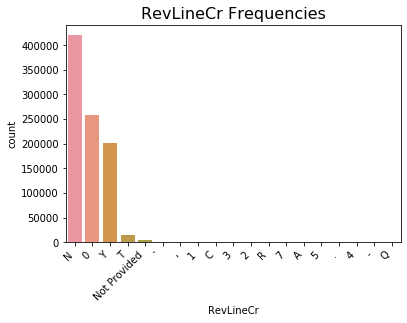

In [26]:
# RevLineCredit: delete special characters 14 total, recode numbers to letters
ax = sns.countplot(x =loans['RevLineCr'] )
plt.title("RevLineCr Frequencies",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

(array([0, 1]), <a list of 2 Text xticklabel objects>)

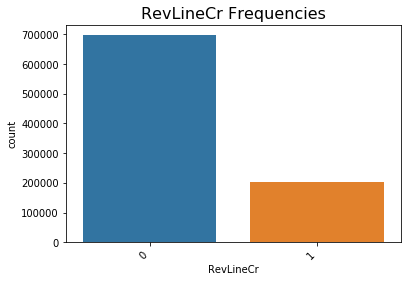

In [27]:
loans['RevLineCr'].replace(to_replace = ['Y','1'], value = 1, inplace = True)
loans['RevLineCr'].replace(to_replace = ['N','0'], value = 0, inplace = True)
no = ['T','`','Not Provided',",",'C','3','2','R','7','A','5','.','4',"'",'Q','-']
loans['RevLineCr'].replace(to_replace = no, value = 0, inplace = True)

ax = sns.countplot(x =loans['RevLineCr'] )
plt.title("RevLineCr Frequencies",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

**LowDoc** has 9 categories when it should have 3.  All values with "Y" will be coded as 1; values with "N" will be coded as 0; all other values will be coded as 0.  We can see that most loan applicants are not part of the LowDoc loan program in the barchart below.  After reorganization we can see that there are 2 categories with 0 being the largest with 788,817 records.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

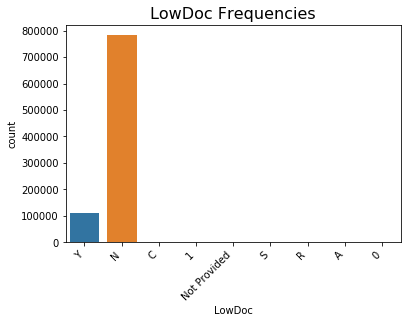

In [28]:
# LowDoc: covert everything to Y or N
ax = sns.countplot(x =loans['LowDoc'] )
plt.title("LowDoc Frequencies",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

In [29]:
loans['LowDoc'].replace(to_replace = ['Y','1'], value = 1, inplace = True)
loans['LowDoc'].replace(to_replace = ['N','0'], value = 0, inplace = True)
no = ['C','S','Not Provided','S','R','A']
loans['LowDoc'].replace(to_replace = no, value = 0, inplace = True)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

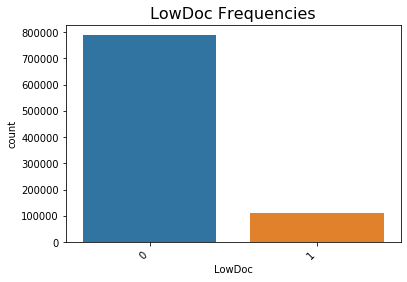

In [30]:
ax = sns.countplot(x =loans['LowDoc'] )
plt.title("LowDoc Frequencies",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

**FRANCHISE CODE** is a feature that describes if a business is a franchise or not and is denoted with '0' being no, and '1' being yes.  All records that were not coded as '0' were recoded to '1'.  Some examples of this would be records with 'Y', which would then be recoded to '1'.  The plot below confirms the cleaning and that two classes remain.

C:\Users\Jeff\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(array([0, 1]), <a list of 2 Text xticklabel objects>)

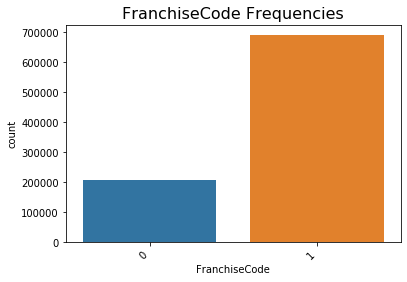

In [31]:
loans['FranchiseCode'].loc[(loans['FranchiseCode'] !=0)] = 1

ax = sns.countplot(x =loans['FranchiseCode'] )
plt.title("FranchiseCode Frequencies",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

There are over 50 categories for the **State** feature, where each category is a state or military address.  If all the states were converted via one-hot-encoding, or dummy coding, there would be a risk of overfitting.  To address this states will be grouped into the following regions: West, Midwest, Southwest, Southeast, and Northeast.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52]),
 <a list of 53 Text xticklabel objects>)

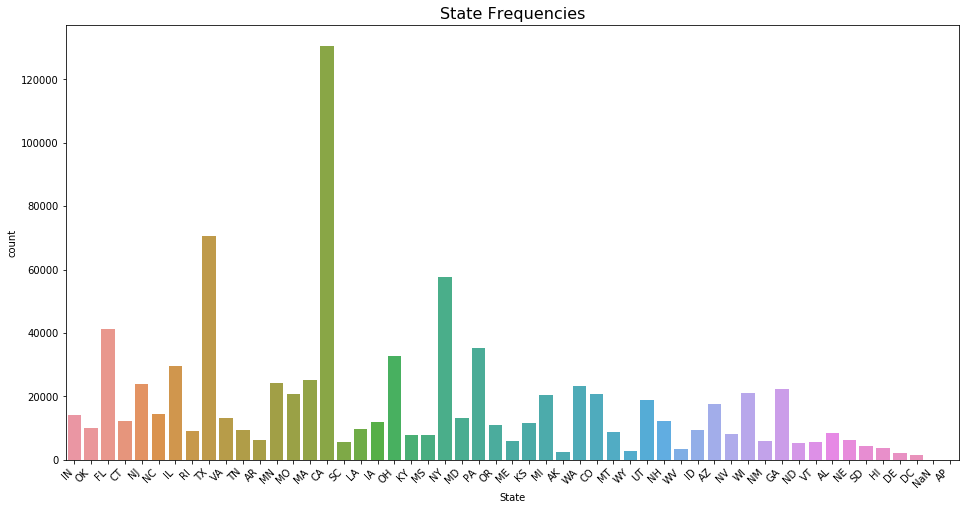

In [32]:
# State Distribution
plt.figure(figsize=(16,8))
ax = sns.countplot(x =loans['State'] )
plt.title("State Frequencies",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

After the **State** feature was binned by region, we can see that the 'West' has the most loan applocations, followed by the 'Northeast' and 'Midwest'.  The code below assigns each state to a region based on this map found on National Geographic:https://www.nationalgeographic.org/maps/united-states-regions/

The binning was confirmed by a barchart to ensure that all states were properly assigned to a region.  The barchart include frequency counts for ease of reading and was generated using a for loop.

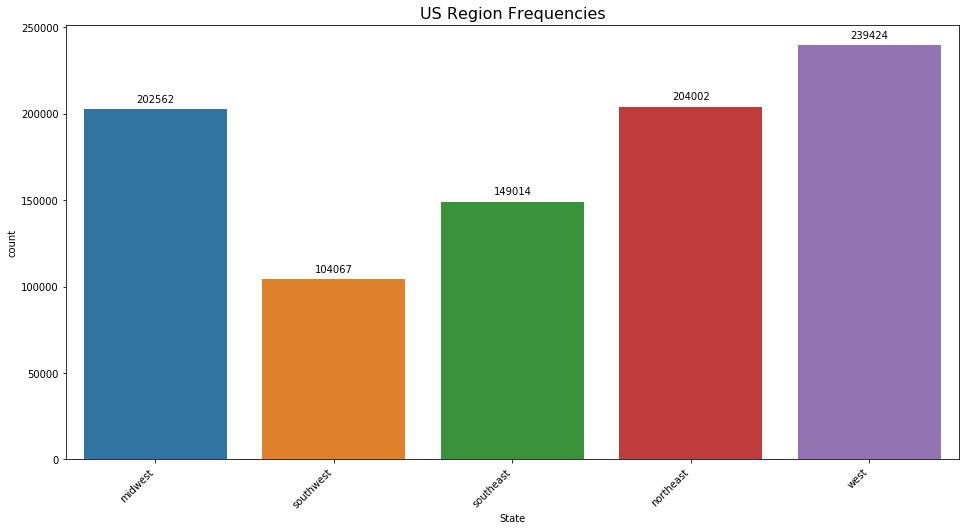

In [33]:
#Generate list of states
west = ['WA','OR','CA','NV','UT','CO','WY','MT','ID','AK','HI','AP','NaN']
midwest =['ND','SD','NE','KS','MO','IA','MN','MI','IL','IN','OH','WI']
southeast = ['AR','LA','MS','TN','KY','WV','VA','NC','SC','GA','FL','AL']
southwest = ['AZ','TX','NM','OK']
northeast = ['ME','VT','NH','CT','RI','NY','NJ','DE','MD','MA','PA','DC']

loans['State'].replace(to_replace = west, value = 'west', inplace = True)
loans['State'].replace(to_replace = midwest, value = 'midwest', inplace = True)
loans['State'].replace(to_replace = southeast, value = 'southeast', inplace = True)
loans['State'].replace(to_replace = southwest, value = 'southwest', inplace = True)
loans['State'].replace(to_replace = northeast, value = 'northeast', inplace = True)

plt.figure(figsize=(16,8))
ax = sns.countplot(x =loans['State'] )
plt.title("US Region Frequencies",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

for p in ax.patches:
    ax.annotate(p.get_height(),
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), textcoords = 'offset points')

#### Categorical One-hot-encoding

**Bank**, **NAICS**, **ApprovalFY_decade**, **UrbanRural**, **NewExist**, and **State** are nominal categorical features and are best represented by one-hot-encoding or as an integer.  For our models, these features will be converted to on hot encoding and the old feature will be removed.  After one-hot-encoding was complete, the .info() function was run to visually check to ensure that the function created new features and removed the old features.  Failure to remove features used to create on-hot-encoded features would introduce multicollinearity.  This property would result in an over-inflation of model metrics.

In [34]:
loans = loans.reset_index(drop=True) #resets index, important when converting to array

In [35]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899069 entries, 0 to 899068
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   LoanNr_ChkDgt       899069 non-null  int64         
 1   Name                899069 non-null  object        
 2   City                899069 non-null  object        
 3   State               899069 non-null  object        
 4   Zip                 899069 non-null  object        
 5   Bank                899069 non-null  object        
 6   BankState           899069 non-null  object        
 7   NAICS               899069 non-null  category      
 8   ApprovalDate        899069 non-null  datetime64[ns]
 9   ApprovalFY          899069 non-null  object        
 10  Term                899069 non-null  int64         
 11  NoEmp               899069 non-null  int64         
 12  NewExist            899069 non-null  Int64         
 13  CreateJob           899069 no

After additional cleaning and binning of the categorical features we can see that the number of unique levels has decreased.  Having fewer levels per features should reduce the computational load and potential overfitting when running our classification algorithms.

### Quantitative Features

The correlation matrix below shows continuous features that help determine if a loan is paid in full or if it defaults.  The correlation matrix shows that **DisbursementGross** is strongly and positively with **SBA_Appr** and **GrAppv**; and **SBA_Appr** is strongly and positively correlated with **GrAppv**. **NoEmp** and **Term** feature show moderate or low correlation compared to the remaining features. **DisbursementGross**, **SBA_Appr** and **GrAppv** all relate to the amount of money a small business is approved for or received and the correlation matrix shows how strongly correlated those values are. It is most likely that values from DisbursementGross, **SBA_Appr** and **GrAppv** are the same or are very close to each other.

One assumption for logistic regression is minimal multicollinearity.  **DisbursmentGross**, **GRAppv**, and **SBA_Appv** are highly correlated (r > 0.90) with each other as they all describe the amount of money that is given to a loan applicant.  Since the **SBA_Appv** feature describes the amount of money that is approved and guaranteed to an applicant it will be kept.  **DisbursementGross** and **GrAppv** will be removed as they are both like **SBA_Appv**, but do not represent the final loan amount an applicant will receive.

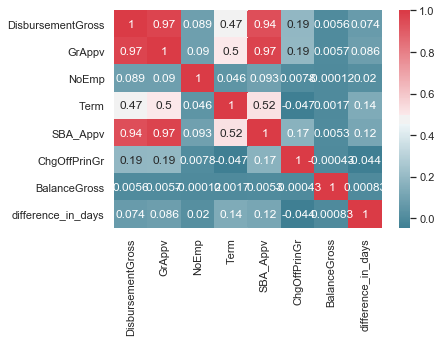

In [36]:
normal_data =['DisbursementGross', 'GrAppv', 'NoEmp', 'Term', 'SBA_Appv','ChgOffPrinGr', 
              'BalanceGross','BankState','difference_in_days']
loans_corr = loans[normal_data]

cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

#Generate a correlation matrix of transformed data
sns.set(style="darkgrid") # one of the many styles to plot using
sns.heatmap(loans_corr.corr(), cmap=cmap, annot=True)

In [37]:
defaults = loans[loans['MIS_Status']==0]
defaults = defaults.reset_index(drop=True)
default_features = ['State','NAICS','Term','SBA_Appv']

chg_off_data = defaults[default_features]

chg_off_data = pd.get_dummies(chg_off_data,columns=['NAICS','State'])

if 'NAICS' in chg_off_data:    
    del chg_off_data['NAICS']
    
if 'State' in chg_off_data:    
    del chg_off_data['State']  
    
chg_off_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157818 entries, 0 to 157817
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Term             157818 non-null  int64  
 1   SBA_Appv         157818 non-null  float64
 2   NAICS_1          157818 non-null  uint8  
 3   NAICS_2          157818 non-null  uint8  
 4   NAICS_3          157818 non-null  uint8  
 5   NAICS_4          157818 non-null  uint8  
 6   NAICS_5          157818 non-null  uint8  
 7   NAICS_6          157818 non-null  uint8  
 8   NAICS_7          157818 non-null  uint8  
 9   NAICS_8          157818 non-null  uint8  
 10  NAICS_9          157818 non-null  uint8  
 11  State_midwest    157818 non-null  uint8  
 12  State_northeast  157818 non-null  uint8  
 13  State_southeast  157818 non-null  uint8  
 14  State_southwest  157818 non-null  uint8  
 15  State_west       157818 non-null  uint8  
dtypes: float64(1), int64(1), uint8(14)
mem

In [38]:
#Standardize Data
%matplotlib inline
# chg_off_data['NAICS']= chg_off_data['NAICS'].astype(float)

y = chg_off_data['SBA_Appv']
chg_off_data['SBA_Appv_std'] =(chg_off_data['SBA_Appv'] - chg_off_data['SBA_Appv'].mean())/chg_off_data['SBA_Appv'].std()
#defaults[['SBA_Apprv_std']]

In [39]:
chg_off_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157818 entries, 0 to 157817
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Term             157818 non-null  int64  
 1   SBA_Appv         157818 non-null  float64
 2   NAICS_1          157818 non-null  uint8  
 3   NAICS_2          157818 non-null  uint8  
 4   NAICS_3          157818 non-null  uint8  
 5   NAICS_4          157818 non-null  uint8  
 6   NAICS_5          157818 non-null  uint8  
 7   NAICS_6          157818 non-null  uint8  
 8   NAICS_7          157818 non-null  uint8  
 9   NAICS_8          157818 non-null  uint8  
 10  NAICS_9          157818 non-null  uint8  
 11  State_midwest    157818 non-null  uint8  
 12  State_northeast  157818 non-null  uint8  
 13  State_southeast  157818 non-null  uint8  
 14  State_southwest  157818 non-null  uint8  
 15  State_west       157818 non-null  uint8  
 16  SBA_Appv_std     157818 non-null  floa

# Modeling and Evaluation 1

## Agglomerative Clustering

Running agglomerative clustering on all 157,818 "CHGOFF" records caused memory errors as the proximity matrix generated by the clustering algorithm was too large for RAM.  A random sample of n = 20000 was taken using pandas' sample() function to avoid memory errors and allow for rapid prototyping.

In [40]:
cluster_sample=chg_off_data.sample(n=20000, replace=False, random_state=45)

### Agglomerative Helper Function

Since there are more than two features that were used for agglomerative clustering, visualizing the clusters was performed by a dendrogram instead of a scatterplot.  A dendrogram is ideal since there were 15 features used for this clustering algorithm.  Since scatterplots are intended for 2-dimensional data, showing clusters based on 15 features on scatter plots would result in a loss of information since only two features can be shown at a time.

Dendrograms show the hierarchical structure of the data as the agglomerative clustering algorithm cluster based on a distance measure such as, but not limited to: euclidiean, manhattan, or cosine distances.  The plot_dendrogram() helper function was used to show the clusters generated by an agglomerative clustering model by showing each data points distance from each other in a hierarchical diagram.  This code was referenced from sklearn [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py).

In [41]:
from sklearn import manifold
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

The **linkage** parameter in the AgglomerativeClustering() function was adjusted to generate different clusters by defining intercluster similarity using either: minimum similarity, maximum similarity, group average, distance between centroids, or the use of an objective function.  For this project, the minimum distance (single linkage) and an objective function (Ward's method) will be used by the clustering algorithm to determine similarity.  Single linkages generate clusters based on minimizing the distance between data, while ward linkages aim to minimize the SSE.

For initial agglomerative modeling, the **distance_threshold** was set to 0 to allow the algorithm to determine the minimal value for distance or SSE based on the **linkage** method.  When **distance_threshold** parameter was set to 0, the algorithm requires that the **n_clusters** parameter be set to "None".  This allows the algorithm to generate its own clusters.

After each agglomerative clustering model was run, it was fit.  Fitting the models allowed for clusters to be identified through the use of dendrograms generated from the labels_ and children_ attributes utilized by the plot_dendrogram() helper function.

In [42]:
#Single Linkage
from sklearn.cluster import AgglomerativeClustering

cluster_model1 = AgglomerativeClustering(linkage='single',distance_threshold=0, n_clusters=None)
cluster_model1.fit(cluster_sample)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=0,
                        linkage='single', memory=None, n_clusters=None)

In [43]:
#Ward
cluster_model2 = AgglomerativeClustering(linkage='ward',distance_threshold=0, n_clusters=None)
cluster_model2.fit(cluster_sample)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=0, linkage='ward',
                        memory=None, n_clusters=None)

After the inital models generated clusters, a final agglomerative model was created to allow for labeling of data.  Based on visual inspection of dendrograms in "Model Evaluation 3" and analysis of summary stats and counts from "Model Evaluation 2" parameters for the final model were set.

Initial models for both single and Ward linkage dendrograms showed there were two clusters.  For the final model, the **n_clusters** parameter was then set to two.  When looking at the dendrograms, the summary statistics and counts between the two linkages, the single linkage clustering were not ideal as one cluster took up most of the records.  We can see that for the Ward linkage that the dendrograms show a more even distribution in the clusters.  Single linkage has a tendancy to be sensitive to outliers, whereas the Ward method is more robust to outliers.  This shows that the single linkage cluster potentially over generalized some of the records into a cluster that may not adequately describe the data. Based on these observations the **linkage** parameter was set to "ward".

The affinity parameter was adjusted to identify if different clustering would be generated.  For the Ward linkage only Euclidean can be used.  For single linkage Manhattan and Euclidean were used.  Three features were created to capture the cluster labels for each linkage-affinity combination. The labels were generated by the fit_predict() function and stored in the .labels_ attribute.

In [44]:
# create 3 models based on adjusting affinity
cluster_model3ward = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster_model3_single_eucl = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='single')
cluster_model3_single_man = AgglomerativeClustering(n_clusters=2, affinity='manhattan', linkage='single')

#Fit models
cluster_model3ward.fit_predict(cluster_sample)
cluster_model3_single_eucl.fit_predict(cluster_sample)
cluster_model3_single_man.fit_predict(cluster_sample)

#label clusters in data
cluster_sample['cluster_ward'] = cluster_model3ward.labels_
cluster_sample['cluster_se'] = cluster_model3_single_eucl.labels_
cluster_sample['cluster_sm'] = cluster_model3_single_man.labels_

# Modeling and Evaluation 2

Explanatory data analysis was preformed on the clusters to determine which model preformed best. For visualizations of this EDA please see the "Model and Evaluation 3" section.

## Agglomerative Clustering EDA

Continuous and categorical features were specified, and Clusters were separated into sets for exploratory data analysis and summary statistics.  The one_hot_counter() helper function was created to provide counts from each one-hot-encoded feature.

one_hot counter() takes a cluster set, and list of one-hot-encoded columns from a feature as arguments.  It uses a loop to iterate over each one-hot-encoded column, counts all non-zero values, adds it to a list, and returns the list.  The list returned by one_hot_counter() can then be used for EDA or visualization.

In [45]:
cluster1w = cluster_sample[cluster_sample['cluster_ward']==0]
cluster2w = cluster_sample[cluster_sample['cluster_ward']==1]

cluster1se = cluster_sample[cluster_sample['cluster_se']==0]
cluster2se = cluster_sample[cluster_sample['cluster_se']==1]

cluster1sm = cluster_sample[cluster_sample['cluster_sm']==0]
cluster2sm = cluster_sample[cluster_sample['cluster_sm']==1]

continuous_var = ['Term','SBA_Appv','SBA_Appv_std']
NAICS = ['NAICS_1', 'NAICS_2', 'NAICS_3', 'NAICS_4', 
           'NAICS_5', 'NAICS_6', 'NAICS_7', 'NAICS_8', 'NAICS_9']
region = ['State_midwest', 'State_northeast', 'State_southeast', 
          'State_southwest', 'State_west']

In [46]:
def one_hot_counter(cluster, variable_name):
    #iterates over a list of one-hot-encoded columns and return a count of non-zero values
    var_count = []
    for var_name in variable_name:
        var_count.append(np.count_nonzero(cluster[var_name]==1))
    return var_count

### Categorical EDA

Clusters for each linkage type were separated in individual sets and filtered for the categorical features.  When looking at NAICS we can see that the Euclidean and Manhattan linkages cluster most of the data into cluster 1.  However, when we look at cluster 2 for both Euclidean and Manhattan linkages there are minimal records.  The Ward method puts more data into cluster 2, but still was able to include a decent number of records into cluster 1.

When the Ward method was used NAICS_7 (Arts and Hospitality) for cluster 1 and NAICS_4 (Trade and Transportation) for cluster 2 are most common.  When Euclidean or Manhattan linkages are used, NAICS_4 (Trade and Transportation) for cluster 1 and NAICS_7 (Trade and Transportation) for cluster 2 are most common.  The main difference between the linkages are that the most common sectors are the same but are flipped for each cluster; and the cluster 2 counts for Euclidean and Manhattan are very low.

In [47]:
c1_naics_ct_w = one_hot_counter(cluster1w, NAICS) 
c2_naics_ct_w = one_hot_counter(cluster2w, NAICS)   
c1_naics_ct_se = one_hot_counter(cluster1se, NAICS)
c2_naics_ct_se = one_hot_counter(cluster2se, NAICS) 
c1_naics_ct_sm = one_hot_counter(cluster1sm, NAICS) 
c2_naics_ct_sm = one_hot_counter(cluster2sm, NAICS) 

d = {'NAICS':NAICS, 'Cluster 1 Counts (Ward)':c1_naics_ct_w,'Cluster 1 Counts (Single Euclidean)':c1_naics_ct_se,
     'Cluster 1 Counts (Single Manhattan)':c1_naics_ct_sm,'Cluster 2 Counts (Ward)':c2_naics_ct_w,
     'Cluster 2 Counts (Single Euclidean)':c2_naics_ct_se,'Cluster 2 Counts (Single Manhattan)':c2_naics_ct_sm,}
pd.DataFrame(data=d)

,NAICS,Cluster 1 Counts (Ward),Cluster 1 Counts (Single Euclidean),Cluster 1 Counts (Single Manhattan),Cluster 2 Counts (Ward),Cluster 2 Counts (Single Euclidean),Cluster 2 Counts (Single Manhattan)
0,NAICS_1,38,101,101,64,1,1
1,NAICS_2,103,1931,1931,1833,5,5
2,NAICS_3,181,1318,1318,1139,2,2
3,NAICS_4,346,5505,5505,5166,7,7
4,NAICS_5,135,3949,3949,3816,2,2
5,NAICS_6,105,900,900,796,1,1
6,NAICS_7,807,4468,4468,3672,11,11
7,NAICS_8,138,1796,1796,1659,1,1
8,NAICS_9,1,2,2,1,0,0


Like the cluster 1 summary stats, the Euclidean and Manhattan distances clustered most of the data into cluster 1, and few records into cluster 2 for the **Region** feature.  For the Ward linkage, most of the data was clustered into cluster 2, however there were still many records for cluster 1.

For the Euclidean and Manhattan distances for single linkage, the region with the most records was the West for cluster 1 and the Southeast for cluster 2.  For the Ward method, the West was most common for cluster 1, and the west was also most common for cluster 2.

In [48]:
c1_region_ct_w =one_hot_counter(cluster1w, region) 
c2_region_ct_w =one_hot_counter(cluster2w, region)
c1_region_ct_se =one_hot_counter(cluster1se, region)  
c2_region_ct_se =one_hot_counter(cluster2se, region)
c1_region_ct_sm =one_hot_counter(cluster1sm, region)   
c2_region_ct_sm =one_hot_counter(cluster2sm, region)

d2 = {'Region': region,'Cluster 1 Counts (Ward)':c1_region_ct_w,'Cluster 1 Counts (Single Euclidean)':c1_region_ct_se,
     'Cluster 1 Counts (Single Manhattan)':c1_region_ct_sm,'Cluster 2 Counts (Ward)':c2_region_ct_w,
     'Cluster 2 Counts (Single Euclidean)':c2_region_ct_se,'Cluster 2 Counts (Single Manhattan)':c2_region_ct_sm,}

pd.DataFrame(data=d2)

,Region,Cluster 1 Counts (Ward),Cluster 1 Counts (Single Euclidean),Cluster 1 Counts (Single Manhattan),Cluster 2 Counts (Ward),Cluster 2 Counts (Single Euclidean),Cluster 2 Counts (Single Manhattan)
0,State_midwest,398,4058,4058,3664,4,4
1,State_northeast,248,4198,4198,3952,2,2
2,State_southeast,432,4072,4072,3651,11,11
3,State_southwest,343,2501,2501,2163,5,5
4,State_west,433,5141,5141,4716,8,8


### Continuous Feature EDA
#### Cluster 1

The Ward linkage Cluster 1's continuous feature summary statistics show that the median **Term** length was 101 months.  The 75th percentile is further from the 50th percentile and the mean is greater than the 50th percentile.  This suggests that this feature is slightly right skewed.

The median **SBA_Appv** amount was $40,500, with the 75th percentile further from the 50th percentile compared to the 25th percentile distance from the 50th percentile.  This also suggests that the data is right skewed for SBA_Appv for this cluster.  **SBA_Appv_std** is the standardized version of **SBA_Apprv**; this feature was used for clustering to reduce the effects of the large dynamic range that is present in **SBA_Appv**.

In [49]:
cluster1w[continuous_var].describe()

,Term,SBA_Appv,SBA_Appv_std
count,1854.000000,1.854000e+03,1854.000000
mean,126.498921,4.940270e+05,2.623507
std,76.275516,2.628003e+05,1.682375
min,0.000000,2.322000e+05,0.947363
25%,73.000000,3.000000e+05,1.381399
50%,101.000000,4.050000e+05,2.053580
75%,184.000000,6.152625e+05,3.399623
max,421.000000,1.500000e+06,9.063468


The Single linkage utlizing the Euclidean distance for Cluster 1's continuous feature summary statistics show that the median **Term** length was 50 months.  The 75th percentile is rougly the same distance as the 25th percental from the median.  This suggests that the data is roughly normal in shape, however the maximum values shows a long thin tail.

The median **SBA_Appv** amount was $25,000, with the 75th percentile closer from the 50th percentile compared to the 25th percentile.  This suggests that the data slightly left skewed for SBA_Appv for this cluster.  **SBA_Appv_std** is the standardized version of **SBA_Apprv**; this feature was used for clustering to reduce the effects of the large dynamic range that is present in **SBA_Appv**.

In [50]:
cluster1se[continuous_var].describe()

,Term,SBA_Appv,SBA_Appv_std
count,19970.000000,1.997000e+04,19970.000000
mean,57.287381,8.285681e+04,-0.008691
std,46.402713,1.509249e+05,0.966179
min,0.000000,1.500000e+02,-0.538157
25%,30.000000,1.250000e+04,-0.459096
50%,50.000000,2.500000e+04,-0.379075
75%,69.000000,7.920000e+04,-0.032101
max,421.000000,1.378875e+06,8.288059


The Single linkage utlizing the Manhattan distance for Cluster 1's continuous feature summary statistics show that the median **Term** length was 50 months.  The 75th percentile is rougly the same distance as the 25th percental from the median.  This suggests that the data is roughly normal in shape, however the maximum values shows a long thin tail.

The median **SBA_Appv** amount was $25,000, with the 75th percentile closer from the 50th percentile compared to the 25th percentile.  This suggests that the data slightly left skewed for SBA_Appv for this cluster.  **SBA_Appv_std** is the standardized version of **SBA_Apprv**; this feature was used for clustering to reduce the effects of the large dynamic range that is present in **SBA_Appv**.

In [51]:
cluster1sm[continuous_var].describe()

,Term,SBA_Appv,SBA_Appv_std
count,19970.000000,1.997000e+04,19970.000000
mean,57.287381,8.285681e+04,-0.008691
std,46.402713,1.509249e+05,0.966179
min,0.000000,1.500000e+02,-0.538157
25%,30.000000,1.250000e+04,-0.459096
50%,50.000000,2.500000e+04,-0.379075
75%,69.000000,7.920000e+04,-0.032101
max,421.000000,1.378875e+06,8.288059


#### Cluster 2

The Ward Cluster 2's continuous feature summary statistics show that the median **Term** length was 47 months.  The 75th percentile is roughly the same distance from the 50th percentile as the 25th percentile.  This suggests that this feature is normal in shape, however there is a long thing tail as shown by the max value.

The mean **SBA_Appv** amount was $25,000, with the 75th percentile further from the 50th percentile compared to the 25th percentile distance from the 50th percentile.  This suggests that the data is right skewed for SBA_Appv for this cluster.  **SBA_Appv_std** is the standardized version of **SBA_Apprv**; this feature was used for clustering to reduce the effects of the large dynamic range that is present in **SBA_Appv**.

In [52]:
cluster2w[continuous_var].describe()

,Term,SBA_Appv,SBA_Appv_std
count,18146.000000,18146.000000,18146.000000
mean,50.375289,43163.301940,-0.262798
std,35.562366,49112.358532,0.314404
min,0.000000,150.000000,-0.538157
25%,28.000000,12500.000000,-0.459096
50%,47.000000,25000.000000,-0.379075
75%,65.000000,50000.000000,-0.219031
max,413.000000,231375.000000,0.942081


The Single linkage utilizing the euclidean distance for Cluster 2's continuous feature summary statistics show that the median **Term** length was 149 months.  The 75th percentile further distance from the 50th percentile compared to the 25th percentile.  This suggests that this featureright skewed in shape.

The mean **SBA_Appv** amount was $1,500,000, with the 75th is the same as the 50th percentile and the 25th percentile is further from the median than the 75th percentile.  This suggests that the data is left skewed for SBA_Appv for this cluster.  **SBA_Appv_std** is the standardized version of **SBA_Apprv**; this feature was used for clustering to reduce the effects of the large dynamic range that is present in **SBA_Appv**.

In [53]:
cluster2se[continuous_var].describe()

,Term,SBA_Appv,SBA_Appv_std
count,30.000000,3.000000e+01,30.000000
mean,153.666667,1.483894e+06,8.960365
std,83.092941,2.848580e+04,0.182358
min,8.000000,1.413225e+06,8.507958
25%,83.000000,1.476225e+06,8.911267
50%,149.000000,1.500000e+06,9.063468
75%,222.750000,1.500000e+06,9.063468
max,284.000000,1.500000e+06,9.063468


The Single linkage utilizing the Manhattan distance for Cluster 2's continuous feature summary statistics show that the median **Term** length was 149 months.  The 75th percentile further distance from the 50th percentile compared to the 25th percentile.  This suggests that this featureright skewed in shape.

The mean **SBA_Appv** amount was $1,500,000, with the 75th is the same as the 50th percentile and the 25th percentile is further from the median than the 75th percentile.  This suggests that the data is left skewed for SBA_Appv for this cluster.  **SBA_Appv_std** is the standardized version of **SBA_Apprv**; this feature was used for clustering to reduce the effects of the large dynamic range that is present in **SBA_Appv**.

In [54]:
cluster2sm[continuous_var].describe()

,Term,SBA_Appv,SBA_Appv_std
count,30.000000,3.000000e+01,30.000000
mean,153.666667,1.483894e+06,8.960365
std,83.092941,2.848580e+04,0.182358
min,8.000000,1.413225e+06,8.507958
25%,83.000000,1.476225e+06,8.911267
50%,149.000000,1.500000e+06,9.063468
75%,222.750000,1.500000e+06,9.063468
max,284.000000,1.500000e+06,9.063468


### Agglomerative Clustering Comparison

When comparing the Ward method versus the Euclidean and Manhattan distances, the Ward method did a better job of creating clusters that had numerous records with distinct summary statistics and categorical feature counts.  Both Euclidean and Manhattan distance measures are not optimal for higher dimensional data, due to the curse of dimensionality as the number of features increase the volume of calculations increases dramatically.

Although the Ward method clustered a large volume into Cluster 2, there were still many records for cluster 1.  When looking at the summary statistics and categorical counts we can see that "CHGOFFS" with a median **Term** of 101 months from the Arts and Hospitality industry and the Southeast are most common in cluster 1; while cluster 2 has a median term of 47 months with Trade and Transportation and the West region being most common.

When looking at the Euclidean and Manhattan distance clustering most data was clustered into cluster 1 with a median **Term** of 50 months from the "Trade and Transportation" Sector and the West region.  Cluster 2 has so few records that it is not informative to use that cluster as most records are in cluster 1.

Given this information, the Ward methods provides 2 clusters with a good volume of records for both clusters with distinct and separate medians and categorical counts.  The use of this model will be explained in "Model and Evaluation 4".

### K-Modes and Agglomerative Clustering Comparison

# Modeling and Evaluation 3

## Agglomerative Clustering Visualizations

The dendrogram generated by the plot_dendrogram() helper function shows the clusters present for agglomerative clustering utilizing single linkages with Euclidean distance as a similarity measure.  We can see that there are two distinct clusters, however most of the data is in the red cluster and few records are in the green cluster.

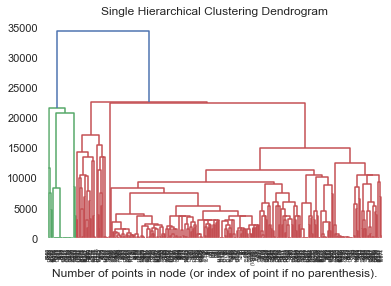

In [55]:
# Single Linkage Dendrogram
plt.title('Single Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(cluster_model1, truncate_mode='level', p=15)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

The dendrogram generated below is for an agglomerative cluster model utilizing the Ward Method with Euclidean distance as a similarity measure.  We can see two distinct clusters with most of the data in the green cluster and a large number of records in the red cluster.

In [ ]:
# Ward Linkage Dendrogram
plt.title('Ward Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(cluster_model2, truncate_mode='level', p=15)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

The two dendrograms above were used to help visually determine how many clusters and which linkage method was ideal for the data for the final model.  Based on visual inspection and the results from the "Model Evaluation 2" section the Ward method yeilds better clusters.

The categorical_plot() helper function was created to visualize counts of a one-hot-encoded feature.  This function has two arguments: cluster and variable_name.  These arguments are fed into one_hot_counter() helper funciton, which then returns a list of counts for each one-hot-encoded level of a feature for visualization.

In [ ]:
def categorical_plot(cluster, variable_name):
    #counts non-zero values from one-hot encoded column and returns a list
    var_count = one_hot_counter(cluster, variable_name)
        
    plt.figure(figsize=(8, 6))
    ax = plt.bar(x = variable_name, height = var_count)
    plt.title("Cluster Frequency",fontsize= 16)
    plt.xticks(rotation=45) 
    print(var_count)

### Ward Method

For cluster 1 we can see that NAICS_7 (Arts and Hospitality) and for cluster 2 NAICS_4 (Trade and Transportation) are most prelvant for their respective clusters.  The "Model Evaluation 2" section goes into more detail for these clusters.

For cluster 1 and cluster 2 the West region is most common. The "Model Evaluation 2" section goes into more detail for these clusters.

In [ ]:
# Cluster 1 NAICS
categorical_plot(cluster1w, NAICS)

In [ ]:
#Cluster 2 NAICS
categorical_plot(cluster2w, NAICS)

In [ ]:
#Cluster 1 Regions
categorical_plot(cluster1w, region)

In [ ]:
#Cluster 2 Regions
categorical_plot(cluster2w, region)

### Euclidean and Manhattan

For cluster 1 we can see that NAICS_4 (Trade and Transportation) and for cluster 2 NAICS_7 (Arts and Hospitality) are most prelvant for their respective clusters.  The "Model Evaluation 2" section goes into more detail for these clusters.

For cluster 1 the West region is most common, for cluster 2 the Southeast region is most common. The "Model Evaluation 2" section goes into more detail for these clusters.

In [ ]:
categorical_plot(cluster1se, NAICS)

In [ ]:
categorical_plot(cluster2se, NAICS)

In [ ]:
categorical_plot(cluster1se, region)

In [ ]:
categorical_plot(cluster2se, region)

# Modeling and Evaluation 4

# Deployment

# Exceptional Work

We would like to have the following considered for exceptional work:
1. EDA was preformed on the K-Modes and Agglomerative Clustering to determine the best clusters
2. plot_dendrogram(), one_hot_counter() and categorical_plot() helper functions were created to reduce the amount of repeated code.
3. K-modes was not covered in class and used as one of the clustering methods.  Additionally there is an appendix explaining the function, its arguments, and attributes.